<a href="https://colab.research.google.com/github/NRafif/Machine-Learning/blob/main/CNN_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARY

In [36]:
from google.colab import files    # Untuk upload files
import zipfile                    # Untuk unzip file
import os                         # Untuk interaksi dengan os
import matplotlib.pyplot as plt   # Untuk visualisasi data
import matplotlib.image as mpimg  # Membaca dan memanipulasi gambar
from google.colab import drive    # Untuk mengakses google drive
import tensorflow as tf           # Library utama untuk Machine learning
import numpy as np                # Library untuk komputasi numerik
from PIL import Image             # Library untuk manipulasi gambar

In [37]:
# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
batch_size = 32
img_height = 224
img_width = 224

# PERSIAPAN DATASET


Load Dataset


In [39]:
cat_disease = "/content/drive/MyDrive/capstone/dataset/CAT SKIN DISEASE"
cat_disease_classes = os.listdir(cat_disease)

In [40]:
print("Cat Skin Disease Class :")
for class_name in cat_disease_classes:
  if os.path.isdir(os.path.join(cat_disease, class_name)):
    print(class_name)

Cat Skin Disease Class :
Scabies
Ringworm
Lepra
Health


Preview Gambar


Scabies
Total Image :  254
Resolusi Gambar :  (1023, 1393, 3)


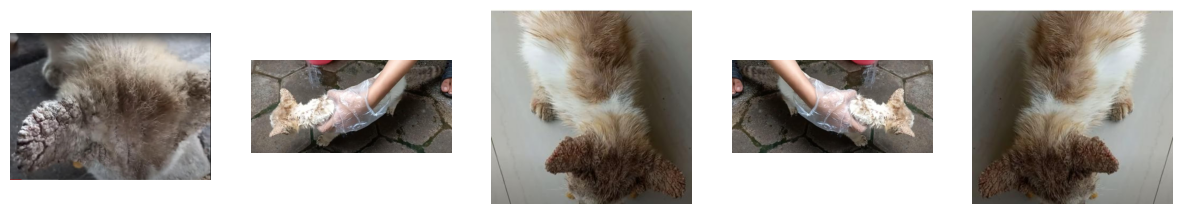


Ringworm
Total Image :  252
Resolusi Gambar :  (640, 640, 3)


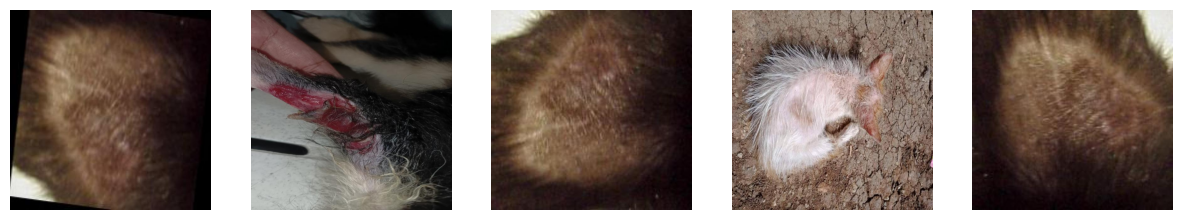


Lepra
Total Image :  256
Resolusi Gambar :  (224, 224, 3)


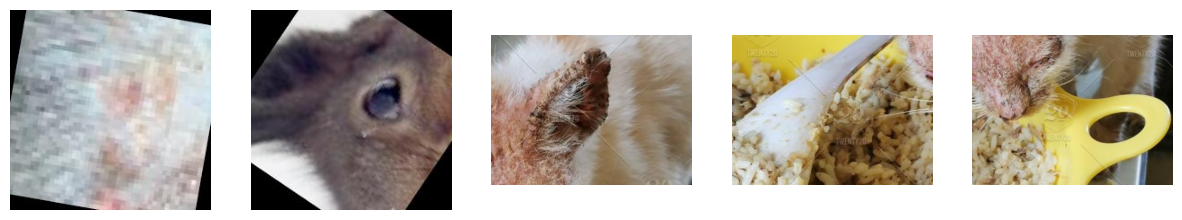


Health
Total Image :  256
Resolusi Gambar :  (640, 640, 3)


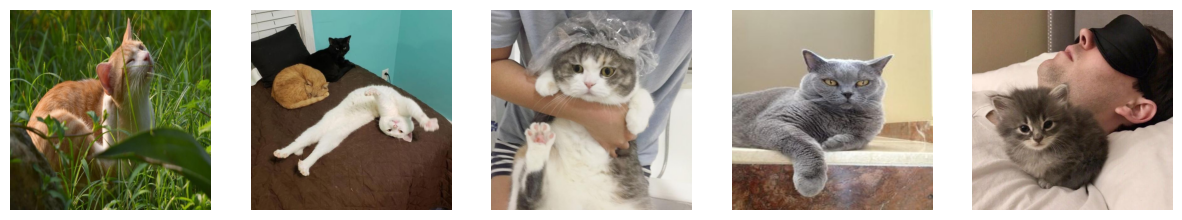

In [41]:
for item in cat_disease_classes:
    print("")
    print(item)
    class_dir = os.path.join(cat_disease, item)
    class_images = [img for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Menghitung total image di setiap kelas
    num_images = len(class_images)
    print("Total Image : ", num_images)

    # Menghitung resolusi pada gambar pertama
    img_path = os.path.join(class_dir, class_images[0])
    img = mpimg.imread(img_path)
    image_shape = img.shape
    print("Resolusi Gambar : ", image_shape)

    # Menampilkan beberapa gambar
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(class_images))):  # Tampilkan maksimum 5 gambar atau sesuai jumlah yang tersedia
        sp = plt.subplot(1, 5, i + 1)
        img = mpimg.imread(os.path.join(class_dir, class_images[i]))
        plt.axis('off')
        plt.imshow(img)
    plt.show()


# PREPOCESING DATA


Split data

In [42]:
def train_val_Dataset():
  training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
      cat_disease,
      image_size=(img_height, img_width),
      color_mode='rgb',
      batch_size= batch_size,
      label_mode='categorical',
      validation_split=0.2,
      subset='both',
      seed=42
  )

  return training_dataset, validation_dataset

In [43]:
# Membuat dataset
training_dataset, validation_dataset = train_val_Dataset()

Found 1020 files belonging to 4 classes.
Using 816 files for training.
Using 204 files for validation.


In [44]:
# Melihat batch pertama dari image dan labels
for image_batch, labels_batch in training_dataset.take(1):
  example_batch = image_batch
  labels_batch = labels_batch

  print(f"maximum pixel value of images : {np.max(example_batch)}.\n")
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Labels batch shape: {labels_batch.shape}")

maximum pixel value of images : 255.0.

Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 4)


Augmentation

In [50]:
def create_augmentation_model():
  augmentation_model = tf.keras.Sequential([
      tf.keras.Input(shape=(224, 224, 3)),
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.2),
  ])

  return augmentation_model


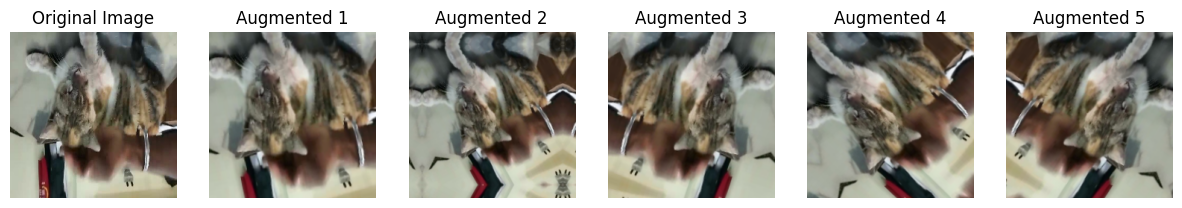

In [51]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch[0])

images = [sample_image]

# Apply random augmentation 5 times
for _ in range(5):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3','Augmented 4','Augmented 5']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

# MODELING

In [52]:
def create_model():

  augmentation_layers = create_augmentation_model()

  model = tf.keras.models.Sequential([
      augmentation_layers,

      # Rescahling input shape
      tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

      # Convolutional and pooling layers
      tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      # Flatten and dense layer
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dropout(0.3),

      # Output layers
      tf.keras.layers.Dense(4, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )


  return model

In [53]:
create_model().summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_18 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_7 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 109, 109, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,640,644 (10.07 MB)

 Trainable params: 2,640,644 (10.07 MB)

 Non-trainable params: 0 (0.00 B)

Buat fungsi callback

In [54]:
class early_stopping_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get('accuracy')>=0.80 and logs.get('val_accuracy')>=0.75:
      print("\nReached 80% train accuracy and 75% validation accuracy so cancelling training!")
      self.model.stop_training = True

Mulai train model

In [55]:
history = create_model().fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping_callback()]
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - accuracy: 0.2811 - loss: 1.3904 - val_accuracy: 0.2451 - val_loss: 1.3829
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.2325 - loss: 1.3902 - val_accuracy: 0.2794 - val_loss: 1.3854
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.2580 - loss: 1.3865 - val_accuracy: 0.2745 - val_loss: 1.3832
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.2815 - loss: 1.3831 - val_accuracy: 0.2647 - val_loss: 1.3820
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.2618 - loss: 1.3849 - val_accuracy: 0.2549 - val_loss: 1.3856
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.2476 - loss: 1.3865 - val_accuracy: 0.3186 - val_loss: 1.3832
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.2644 - loss: 1.3837 - val_accuracy: 0.2696 - val_loss: 1.3656
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.2756 - loss: 1.3741 - val_acc

# Hasil Model

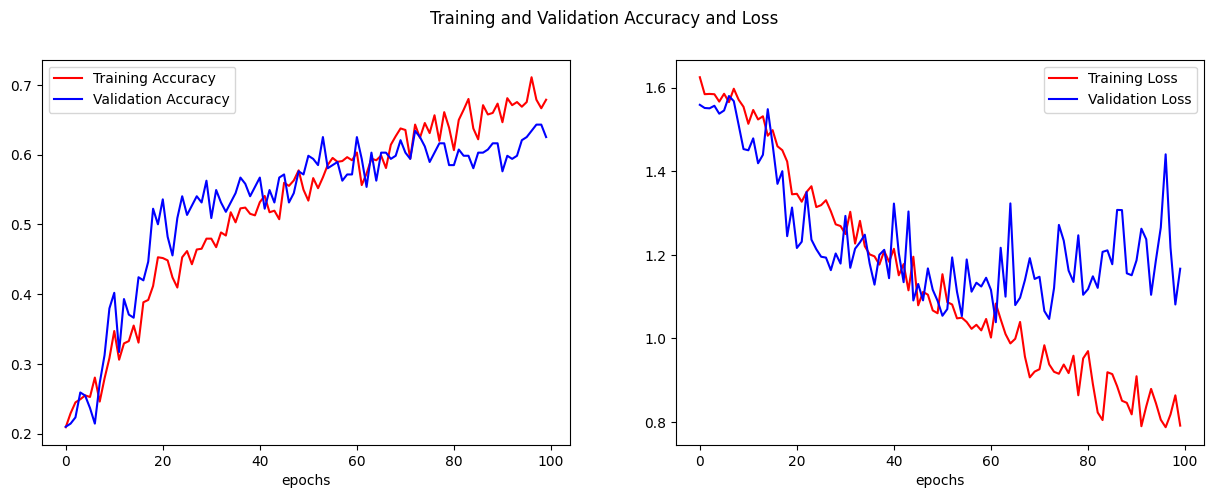

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and Validation Accuracy and Loss')

# Define data and labels for each subplot
data_labels = [
    (acc, val_acc, 'Accuracy'),
    (loss, val_loss, 'Loss')
]

# Iterate through subplots and data
for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    axs[i].plot(epochs_range, data[0], 'r', label="Training " + label)
    axs[i].plot(epochs_range, data[1], 'b', label="Validation " + label)
    axs[i].legend()
    axs[i].set_xlabel('epochs')

plt.show()

# Mengetes Model

Saving images (1).jpeg to images (1) (1).jpeg
User uploaded file "images (1) (1).jpeg" with length 9045 bytes


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Predicted class: Dermatitis
Prediction probabilities: [[0.19997582 0.19999076 0.20000894 0.20000283 0.20002167]]


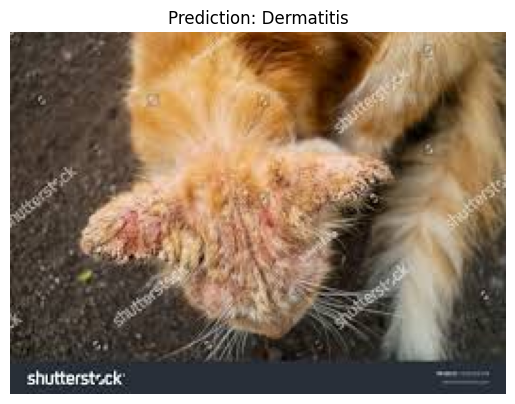

In [21]:
def predict_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((img_height, img_width))  # Resize image
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Assuming class names are stored in cat_disease_classes
    predicted_class_name = cat_disease_classes[predicted_class]

    return predicted_class_name, prediction


# Upload a file
uploaded = files.upload()

# Get the uploaded file name
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Make prediction
image_path = fn # Use the uploaded file name
predicted_class_name, prediction = predict_image(image_path, create_model()) # use the trained model

print(f"Predicted class: {predicted_class_name}")
print(f"Prediction probabilities: {prediction}")

# Display the uploaded image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}")
plt.show()